# **Feature Engineering of Warsaw Rental Prices**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('warsaw_rent.csv')

In [3]:
plt.rcParams.update({
    "xtick.major.size": 5,
    "xtick.major.pad": 20,
    "xtick.labelsize": 20,
    "grid.color": "0.5",
    "grid.linestyle": "-",
    "grid.linewidth": 5,
    "lines.linewidth": 2,
    "lines.color": "g",
    "figure.figsize": (10, 5),
    'axes.titlesize': 25,
    'axes.titlepad' : 20,
    'figure.autolayout': True,
})
plt.style.use('fivethirtyeight')

## **Step 1 : Removing and reshaping columns** 

In [4]:
df = df.drop(['Dishwasher','TV','Internet','Balcony','Garden','Floor','Heating','Rooms',
         'Building material','Windows'],axis = 1)

In [5]:
df = df[df['Price'].notna()]
df['Type of building'].fillna(df['Type of building'].mode()[0], inplace=True)

In [6]:
# Function to combine categories with frequency below 10% in given column 
def combine_rares(col):
    frequencies = df[col].value_counts(normalize=True, ascending=True)
    threshold = frequencies[(frequencies.cumsum() > 0.1).idxmax()]
    df[col] = df[col].mask(df[col].map(df[col].value_counts(normalize=True)) < 0.01, 'Other')

In [7]:
df.shape

(2212, 13)

In [8]:
combine_rares('Type of building')

In [9]:
y = df['Price']
df = df.drop(['Price'],axis = 1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=23)

In [11]:
X_train.shape

(1769, 12)

In [12]:
X_test.shape

(443, 12)

In [13]:
y_train.shape

(1769,)

In [14]:
y_test.shape

(443,)

### **Step 2. Scaling, transforming and encoding the data**

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

cat = df.select_dtypes([object,bool]).columns
numx = ['Area']

In [16]:
num_pipeline = Pipeline([
       ("log", FunctionTransformer(np.log, inverse_func = np.exp,
                                   validate=True, check_inverse = True)),
        ("scale", RobustScaler())])
      
full_pipeline = ColumnTransformer(transformers=[
        ("num", num_pipeline, numx),
        ("oht", OneHotEncoder(drop='first',sparse=False), cat)])

In [17]:
X_train = full_pipeline.fit_transform(X_train) 
X_test = full_pipeline.transform(X_test) 

In [18]:
X_train.shape

(1769, 30)

In [19]:
X_test.shape

(443, 30)

In [20]:
y_train = num_pipeline.fit_transform(y_train.values.reshape(-1, 1))
y_test = num_pipeline.transform(y_test.values.reshape(-1, 1))

In [21]:
y_train.shape

(1769, 1)

In [22]:
y_test.shape

(443, 1)

### **Step 3. Further feature selection** 

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
rfecv = RFECV(
    estimator=LinearRegression(),
    min_features_to_select=5,
    step=1,
    n_jobs=10,
    cv = 3
)
rfecv.fit(X_train, y_train)
rfecv.transform(X_train)
print(rfecv)
print(rfecv.n_features_)

RFECV(cv=3, estimator=LinearRegression(), min_features_to_select=5, n_jobs=10)
27


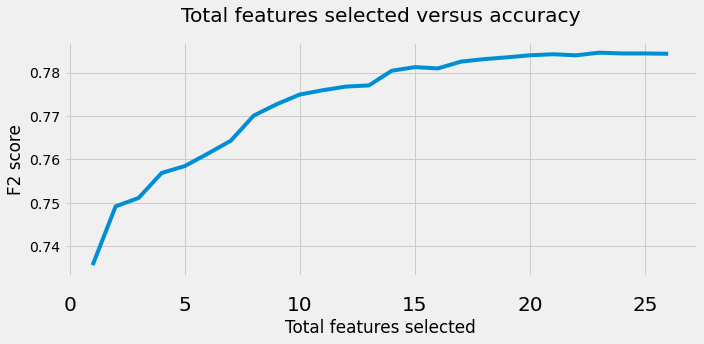

In [24]:
plt.figure( )
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('F2 score')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
ohe0 = pd.get_dummies(df['District'],drop_first = True)
ohe1 = pd.get_dummies(df['Type of building'],drop_first = True)
copy = df.copy()
copy = pd.get_dummies(df, columns=cat,drop_first = True)
data = {'Feature': copy.columns,
        'Rank': rfecv.ranking_,
       'Support' : rfecv.support_}
 
ranking = pd.DataFrame(data)

In [26]:
ranking[ranking['Support'] == False]

,Feature,Rank,Support
13,District_Rembertów,2,False
14,District_Targówek,4,False
16,District_Ursynów,3,False


In [27]:
ranking 

,Feature,Rank,Support
0,Area,1,True
1,Type of building_Block of flats,1,True
2,Type of building_Other,1,True
3,Type of building_Tenement house,1,True
4,Advertiser_Private,1,True
5,Elevator_True,1,True
6,Parking space_True,1,True
7,District_Białołęka,1,True
8,District_Bielany,1,True
9,District_Mokotów,1,True


**The 3 features without RFECV support happened to be one hour encoded categories from district column and have little impact on F2 score, so except modeling with them included will bear weak results - they are staying.**


### **Step 5. Saving Results**

In [28]:
import joblib
dataset_dict = {"X_train": X_train, "X_test": X_test,"y_train": y_train, "y_test": y_test}
joblib.dump(full_pipeline, 'full_pipeline.pkl')
joblib.dump(num_pipeline, 'num_pipeline.pkl')
joblib.dump(dataset_dict, 'dataset_dict.pkl')
ranking.to_csv('ranking.csv', index=False)